## Lightwave Explorer Pulse Consideration in YAG Experiment

In this section I explore how changing different pulse parameters and even super imposing several pulses allows one to achieve real world pulse characteristics. The motivation for this is that I am trying to replicate the results from [this](https://opg.optica.org/oe/fulltext.cfm?uri=oe-21-23-28095&id=274338) paper, and in that process I had issues getting the LWE simulation to converge and produce reasonable results. I ended up asking Nick Karpowicz (the creator of LWE) how I could resolve this issue and he returned to me a simulation with a modifed seed pulse that more accurately represented the seed pulse used in the paper. The methods he used to contruct this pulse were a bit confusing to me at first, so in this section I deconstruct how he created this pulse step by step to gain a full understanding of why he did what he did.

### Initial Pulse Parameters

In the Hemmer et al. paper they characterize the seed pulses from their OPA as follows:

$E_{pulse} = 3$ (uJ)

$\Delta t_{FWHM} = 70$ (fs)

$\lambda_{0} = 3100$ (nm)

$M^2 = 1.8$

$b_{confocal} = 5$ (mm)

The first thing one must do to input this pulse into LWE is convert the confocal parameter into a beam waist using the following formula:

$z_{R} = \frac{b_{confocal}}{2} =\frac{\pi \omega_{0}^2}{\lambda}$

$\omega_{0} = 49.7$ (um)

Additionally, LWE takes the bandwidth of the pulse rather than its temporal length as an input. If the pulse is assumed to be close to transform limited guassian pulse:

$\Delta v = 5.345$ (THz)

In [1]:
import os
import sys
parent_dir = os.path.dirname(os.getcwd())
os.chdir(parent_dir)
sys.path.append(os.getcwd())
from lwe import LightwaveExplorer as lwe
import lwe_util.lwe_util as util
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert

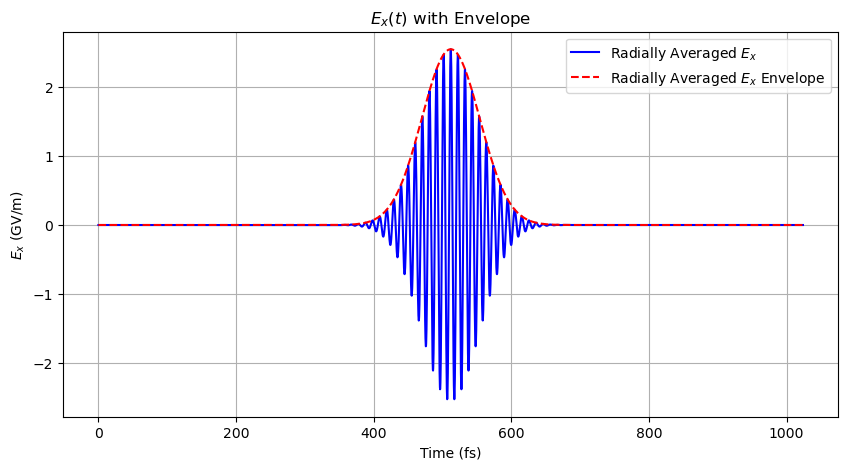

averaged symmetrically over 5.2e-05 meters


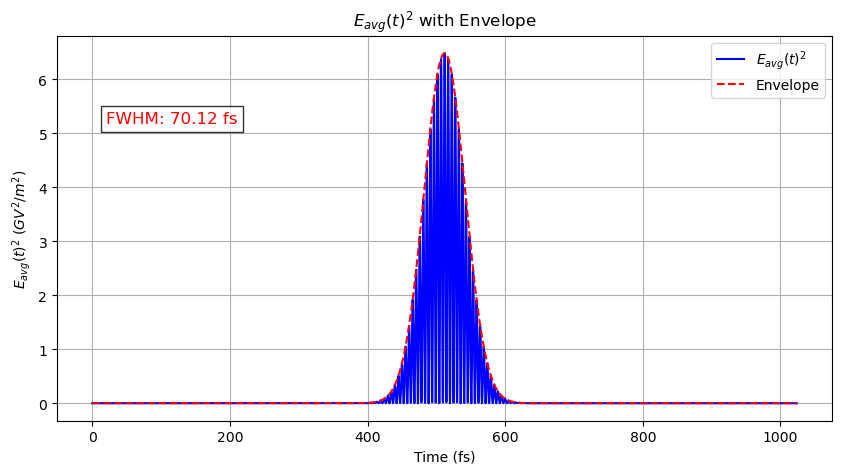

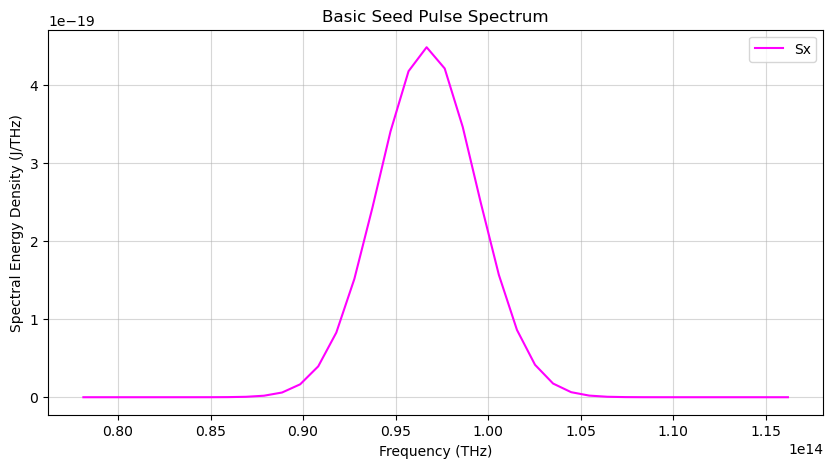

In [2]:
# Import data
path1 = "./examples/data/basic_seed.zip"
sim1 = lwe.load(path1)
data_keys = {
    "Ex": True,
    "Ey": False,
    "freq": True,
    "spectrum_x": True,
    "spectrum_y": False,
    "time": True
}
pulse1 = util.import_data(sim1, data_keys)

# Radially average and calculate pulse duration
radius = 50e-06 # (m)
dx = sim1.spatialStep
pulse1_avg = util.radially_average(pulse1["Ex"], radius, dx, pulse1["time"])
pulse1_duration = util.calculate_pulse_duration(pulse1["Ex"], radius, dx, pulse1["time"])

plt.figure(figsize=(10,5))
plt.plot(pulse1["freq"][80:120], pulse1["spectrum_x"][80:120], color='magenta', label="Sx")
plt.xlabel("Frequency (THz)")
plt.ylabel("Spectral Energy Density (J/THz)")
plt.title("Basic Seed Pulse Spectrum")
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()


### Modified Pulse Parameters

The real seed pulse is not perfectly symmetric. To more accuratley represent this pulse the bandwidth is broadened and some third order disperison is added.

$\Delta v = 7$ (THz)

$TOD = 100000$ (fs^3)

Additionally, the super guassian order is increased by 2 to make the top of the beam flatter.

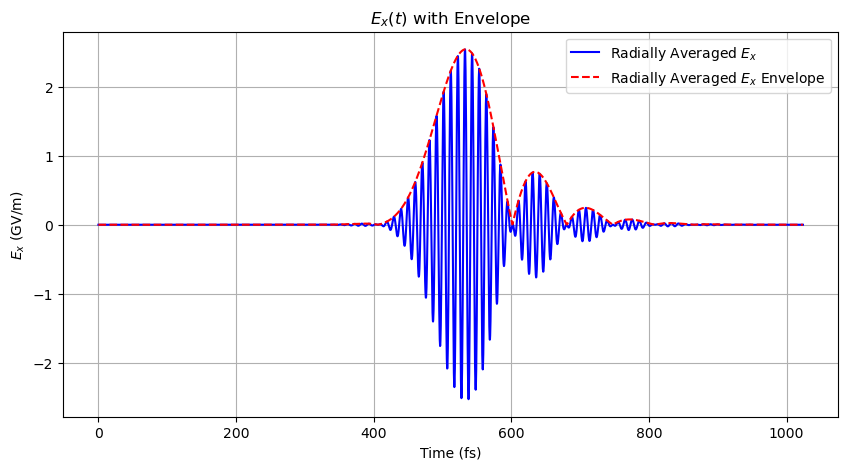

averaged symmetrically over 5.2e-05 meters


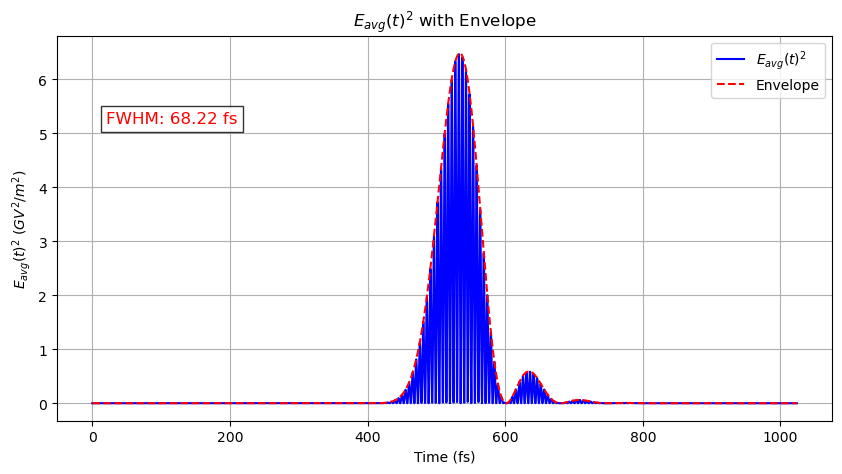

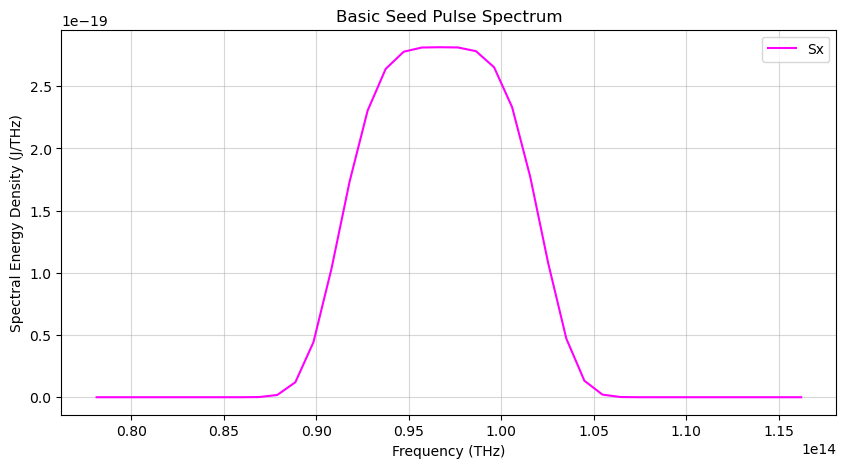

In [3]:
path2 = "./examples/data/modified_seed_1.zip"
sim2 = lwe.load(path2)
pulse2 = util.import_data(sim2, data_keys)
pulse2_avg = util.radially_average(pulse2["Ex"], radius, dx, pulse2["time"])
pulse2_duration = util.calculate_pulse_duration(pulse2["Ex"], radius, dx, pulse2["time"])

plt.figure(figsize=(10,5))
plt.plot(pulse2["freq"][80:120], pulse2["spectrum_x"][80:120], color='magenta', label="Sx")
plt.xlabel("Frequency (THz)")
plt.ylabel("Spectral Energy Density (J/THz)")
plt.title("Basic Seed Pulse Spectrum")
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()


Next, a smaller out of phase duplicate of the beam is added to give the pulse a more flat top focus. Nick hypithesizes that the perfect TEM00 that the simulation produces self focues too efficiently. Finally, the pulses are instantied in air so that the simulation allows for refraction on the front surface of the YAG plate.

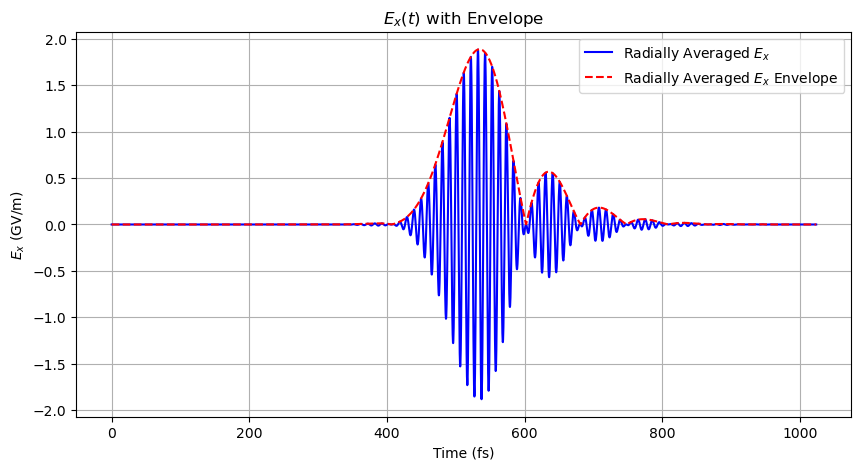

averaged symmetrically over 5.2e-05 meters


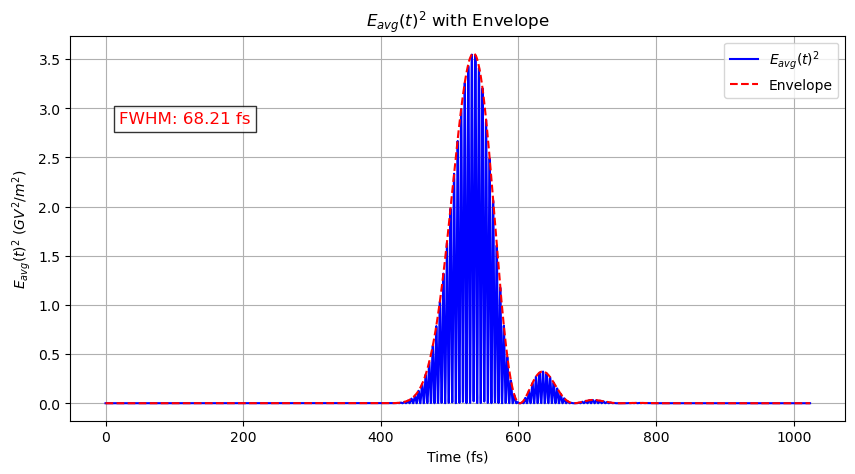

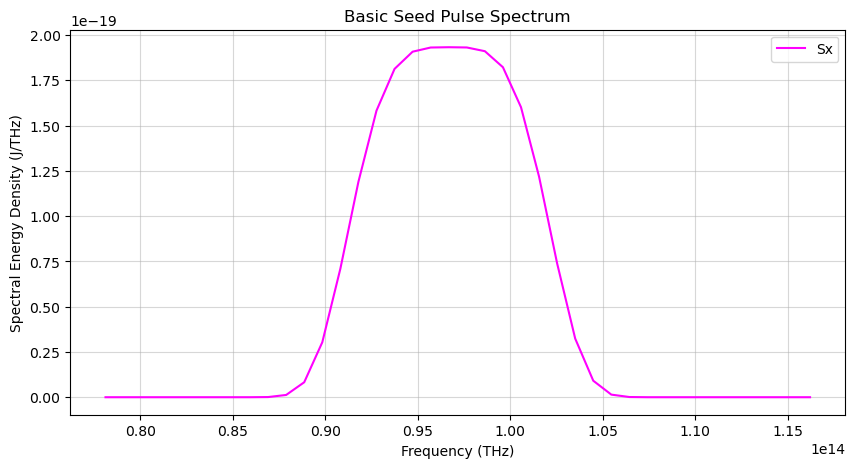

In [4]:
path3 = "./examples/data/modified_seed_2.zip"
sim3 = lwe.load(path3)
pulse3 = util.import_data(sim3, data_keys)
pulse3_avg = util.radially_average(pulse3["Ex"], radius, dx, pulse3["time"])
pulse4_duration = util.calculate_pulse_duration(pulse3["Ex"], radius, dx, pulse3["time"])

plt.figure(figsize=(10,5))
plt.plot(pulse3["freq"][80:120], pulse3["spectrum_x"][80:120], color='magenta', label="Sx")
plt.xlabel("Frequency (THz)")
plt.ylabel("Spectral Energy Density (J/THz)")
plt.title("Basic Seed Pulse Spectrum")
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

## Lightwave Explorer Material Parameters Considerations in YAG Experiment

The photoionization/nonlinear absorption model used in LWE is a simple multiphoton absorption model. The bandgap of YAG is about 6.5 eV and when working with pulses at 3.1 um it needs 17 photons to cover the entire bandgap. The resulting nonlinear polarization is extremely nonlinear and hard to work with numerically (Nick). These effects are handled better by a more complicated photoionization model which is not yet implemented into LWE. To overcome this Nick reccomends lowering the bandgap of the material, with the justification that the fields of interest are in the regime where a more complete Keldysh-type response would be dropping in slope. The parameters used are:

$E_{gap} = 1.5$ (eV)

$\gamma_{drude} = 10$ (THz)

$NL_{absorption} = 2 * 10^{-20}$

$m_{eff}=0.2$

## Simulation Results

Ater adjusting both the material and pulse parameters the simulations representing the experiments in the Hemmer et al. paper were done. The results for these simulations are below. While they agree qualitatively it seems that getting an exact match is unlikely. This computation is at the edge of where LWE is effective, and until a more robust multiphoton ionization moodel is implemented this may be as good as it gets. Despite this the same overall trend is present in both the broadened spectrum and compressed pulse durations.

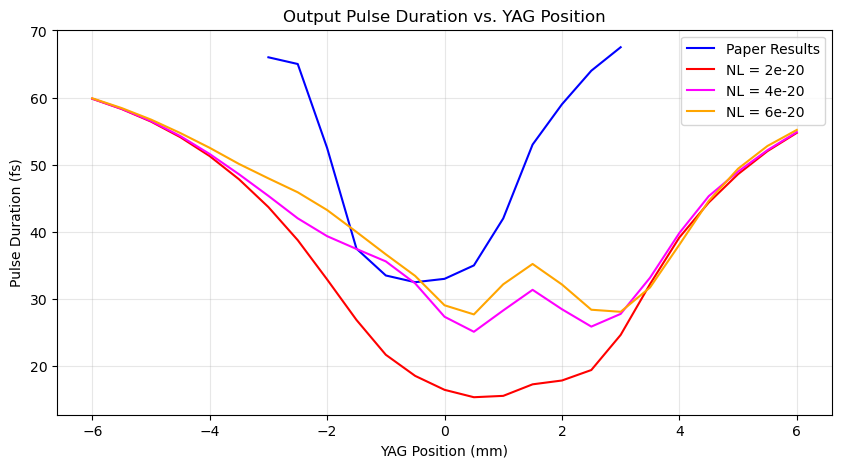

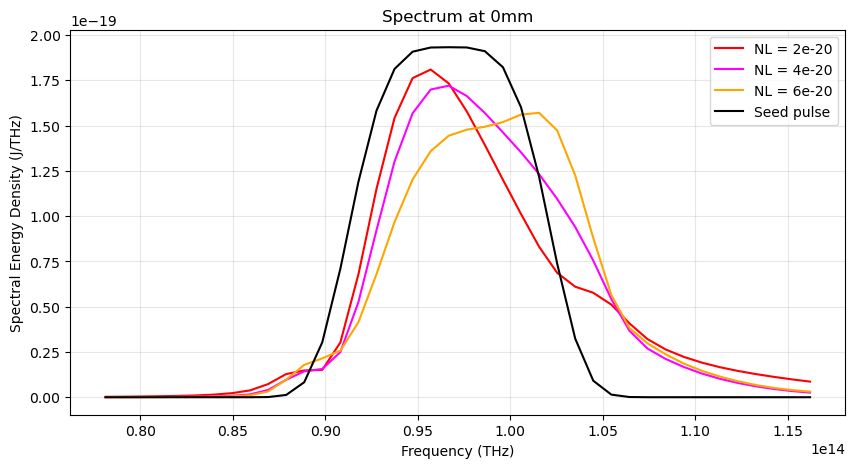

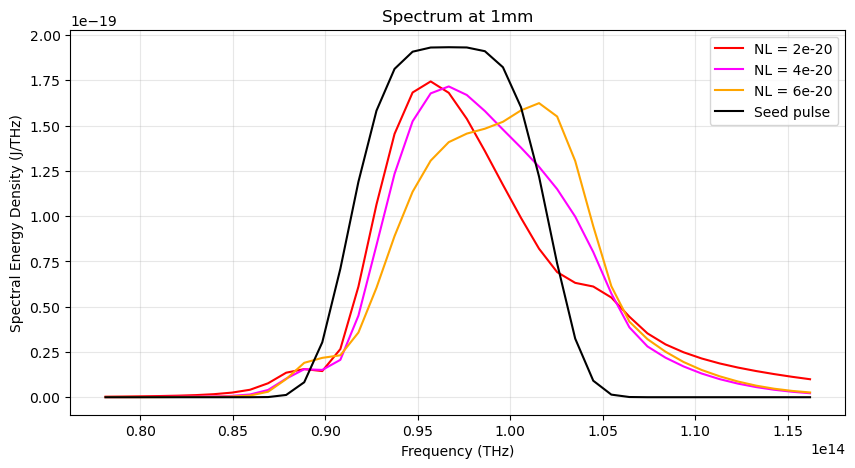

In [9]:
file_paths = [
    "./examples/data/hemmer_2/0mm.zip",
    "./examples/data/hemmer_2/2.zip",
    "./examples/data/hemmer_2/NL-3.zip"
]
labels = ["NL = 2e-20", "NL = 4e-20", "NL = 6e-20"]
colors = ["red", "magenta", "orange"]
hemmer_pulse_durations = [66, 65, 52.5, 37.5, 33.5, 32.5, 33, 35, 42, 53, 59, 64, 67.5]
position_axis1 = [-3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
position_axis2 = [-6.0, -5.5, -5.0, -4.5, -4.0, -3.5, -3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0]
freq = pulse3["freq"][80:120]
radius = 40e-06


plt.figure(figsize=(10,5))
plt.plot(position_axis1, hemmer_pulse_durations, color="blue", label="Paper Results")
for idx, file in enumerate(file_paths):
    pulse_durations = []
    sim_yag = lwe.load(file)
    pulses = util.import_data(sim_yag, data_keys)

    for i in range(0, np.shape(pulses["Ex"])[2]):
        Ex = pulses["Ex"][:,:,i]
        time = pulses["time"]
        pulse_duration = util.calculate_pulse_duration(Ex, radius, dx, time, verbose=False)
        pulse_durations.append(pulse_duration * 1e15)

    plt.plot(position_axis2, pulse_durations, color=colors[idx], label=labels[idx])

plt.xlabel("YAG Position (mm)")
plt.ylabel("Pulse Duration (fs)")
plt.title("Output Pulse Duration vs. YAG Position")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


plt.figure(figsize=(10,5))
for idx, file in enumerate(file_paths):
    sim_yag = lwe.load(file)
    pulses = util.import_data(sim_yag, data_keys)
    spectrum = pulses["spectrum_x"][12][80:120] # spectrum at 0mm
    plt.plot(freq, spectrum, color=colors[idx], label=labels[idx])

plt.plot(pulse3["freq"][80:120], pulse3["spectrum_x"][80:120], color='black', label="Seed pulse")
plt.xlabel("Frequency (THz)")
plt.ylabel("Spectral Energy Density (J/THz)")
plt.title("Spectrum at 0mm")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


plt.figure(figsize=(10,5))
for idx, file in enumerate(file_paths):
    sim_yag = lwe.load(file)
    pulses = util.import_data(sim_yag, data_keys)
    spectrum = pulses["spectrum_x"][14][80:120] # spectrum at 0mm
    plt.plot(freq, spectrum, color=colors[idx], label=labels[idx])

plt.plot(pulse3["freq"][80:120], pulse3["spectrum_x"][80:120], color='black', label="Seed pulse")
plt.xlabel("Frequency (THz)")
plt.ylabel("Spectral Energy Density (J/THz)")
plt.title("Spectrum at 1mm")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()